In [1]:
"""
Read predicted dataset, match links to given offers and send an email notification
with summary of the most interesting offers.
"""
import os
import logging as log

import pandas as pd

import columns
from common import (
    CONCATED_DATA_PATH,
    PREDICTED_DATA_PATH,
    logs_conf,
)
from s3_client import s3_client


log.basicConfig(**logs_conf)

s3_client = s3_client()

def notify_task():
    log.info("Starting notify task...")

    predicted_df_s = s3_client.read_newest_df_from_s3(PREDICTED_DATA_PATH, dtype='sale')
    concated_df_s = s3_client.read_newest_df_from_s3(CONCATED_DATA_PATH, dtype='sale')
    df_s = predicted_df_s.merge(concated_df_s[[columns.OFFER_ID, columns.URL, columns.TITLE]],
                                on=columns.OFFER_ID,
                                how='left')
    
    predicted_df_r = s3_client.read_newest_df_from_s3(PREDICTED_DATA_PATH, dtype='rent')
    concated_df_r = s3_client.read_newest_df_from_s3(CONCATED_DATA_PATH, dtype='rent')
    df_r = predicted_df_r.merge(concated_df_r[[columns.OFFER_ID, columns.URL, columns.TITLE]],
                                on=columns.OFFER_ID,
                                how='left')
    return df_s, df_r

#    notification_html = prepare_notification(predicted_df_s, concated_df_s, predicted_df_r, concated_df_r)
#    response = send_notification(notification_html)
#    if response:
#        log.info("Successfully finished notifiation task.")
#

credentials.py 20:32:17 INFO: Found credentials in shared credentials file: ~/.aws/credentials


In [2]:
df_s, df_r = notify_task() 

<ipython-input-1-94cdfc4b0488> 20:32:18 INFO: Starting notify task...
s3_client.py 20:32:18 INFO: Downloading sale/predicted/sale_predicted_2020_01_02T20_30_17.parquet from flats-data bucket ...
s3_client.py 20:32:26 INFO: Successfully downloaded sale/predicted/sale_predicted_2020_01_02T20_30_17.parquet from flats-data bucket.
s3_client.py 20:32:26 INFO: Downloading sale/concated/sale_concated_2020_01_02T00_20_10.csv from flats-data bucket ...
s3_client.py 20:35:19 INFO: Successfully downloaded sale/concated/sale_concated_2020_01_02T00_20_10.csv from flats-data bucket.
s3_client.py 20:35:26 INFO: Downloading rent/predicted/rent_predicted_2020_01_02T20_25_30.parquet from flats-data bucket ...
s3_client.py 20:35:29 INFO: Successfully downloaded rent/predicted/rent_predicted_2020_01_02T20_25_30.parquet from flats-data bucket.
s3_client.py 20:35:29 INFO: Downloading rent/concated/rent_concated_2020_01_02T00_17_47.csv from flats-data bucket ...
s3_client.py 20:37:00 INFO: Successfully downl

In [3]:
df_s.head()

,balcony__offer,basement__clean,building_height__offer,building_material__offer,building_type__offer,building_year__offer,date_added__offer,date_refreshed__offer,desc_len__offer,direct__offer,...,view_count__offer,water__offer,cluster_mean_price_m2__feature,cluster_mean_price__feature,cluster_id__feature,cluster_center_dist_km__feature,cluster_coords_factor__feature,sale__prediction,url__offer,title__offer
0,1.0,1.0,4.0,3,3,1935.0,2020-01-01,2020-01-01,243.0,0.0,...,49.0,1,363911.25,347647.058824,1409,1.34,519428.874596,4637.628737,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Szczecin, Centrum, Bohaterów Getta Warszawskiego"
1,1.0,1.0,8.0,3,3,2019.0,2020-01-01,2020-01-01,1993.0,0.0,...,23.0,1,267886.35,308409.433333,1209,7.68,298741.720628,7833.005264,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Gliwice, Pszczyńska"
2,1.0,1.0,3.0,3,2,1930.0,2020-01-01,2020-01-01,1888.0,0.0,...,46.0,1,363911.25,347647.058824,1409,2.70,462345.450196,4573.259524,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Szczecin, Drzetowo, Radogoska"
3,1.0,0.0,4.0,1,2,1980.0,2020-01-01,2019-12-31,1384.0,0.0,...,43.0,0,227172.96,191877.777778,1065,1.20,330668.615848,4190.632242,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Lubiński, Lubin, Przylesie"
4,1.0,0.0,4.0,3,2,2019.0,2020-01-01,2020-01-01,3792.0,0.0,...,22.0,0,293525.01,308099.318182,1272,0.59,478248.107635,5497.532340,https://www.morizon.pl/oferta/sprzedaz-mieszka...,"Łódź, Stefana Żeromskiego"


In [7]:
df_s['price_diff'] = df_s[columns.PRICE_M2] - df_s[columns.SALE_PRED]
df_s = df_s[df_s[columns.DATE_ADDED] > '2019-12-01']
df_s = df_s[df_s[columns.PRICE_M2]<20000]
top_10 = df_s.sort_values('price_diff')
top_10 = top_10[[columns.DATE_ADDED, columns.TITLE, columns.URL, columns.PRICE_M2, columns.SALE_PRED]]
top_10

,date_added__offer,title__offer,url__offer,price_m2__offer,sale__prediction
181608,2019-12-09,"Kraków M., Kraków, Stare Miasto",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-krakow-stare-miasto-158m2-mzn2035279105,4367.09,13535.187687
180311,2019-12-09,"Warszawa, Wola, Nowolipki, al. Solidarności",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-warszawa-wola-solidarnosci-18m2-mzn2035276953,1944.44,9831.192290
165096,2019-12-03,"Lublin, Śródmieście, Szewska",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-lublin-srodmiescie-szewska-240m2-mzn2035262426,1662.50,9081.872629
189428,2019-12-18,"Zieona Góra, Os. Zacisze",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-96m2-mzn2035414473,4334.37,11545.199744
188184,2019-12-17,"Lublin (Grodzki), Lublin, Czechów, Harnasie",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-lublin-czechow-harnasie-83m2-mzn2035411282,5892.22,13009.058647
...,...,...,...,...,...
180325,2019-12-09,"Łódź, Pabianicka",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-lodz-pabianicka-13m2-mzn2035276708,10389.61,4097.637347
185795,2019-12-13,"Kraków, Wola Justowska, Królowej Jadwigi",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-krakow-zwierzyniec-krolowej-jadwigi-92m2-mzn20...,19978.40,13009.383041
181537,2019-12-09,"Gdańsk, Śródmieście",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-gdansk-srodmiescie-42m2-mzn2035278475,14871.19,7331.251933
165686,2019-12-03,"Warszawa, Wilanów, Warszawa, Wilanów, Ostra",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-warszawa-wilanow-ostra-251m2-mzn2035265038,18500.00,10847.441766


In [8]:
pd.options.display.max_colwidth=100 
top_10.head(50)

,date_added__offer,title__offer,url__offer,price_m2__offer,sale__prediction
181608,2019-12-09,"Kraków M., Kraków, Stare Miasto",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-krakow-stare-miasto-158m2-mzn2035279105,4367.09,13535.187687
180311,2019-12-09,"Warszawa, Wola, Nowolipki, al. Solidarności",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-warszawa-wola-solidarnosci-18m2-mzn2035276953,1944.44,9831.192290
165096,2019-12-03,"Lublin, Śródmieście, Szewska",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-lublin-srodmiescie-szewska-240m2-mzn2035262426,1662.50,9081.872629
189428,2019-12-18,"Zieona Góra, Os. Zacisze",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-96m2-mzn2035414473,4334.37,11545.199744
188184,2019-12-17,"Lublin (Grodzki), Lublin, Czechów, Harnasie",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-lublin-czechow-harnasie-83m2-mzn2035411282,5892.22,13009.058647
184130,2019-12-12,"Tczewski, Tczew, Strzelecka",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-tczewski-tczew-strzelecka-69m2-mzn2035403806,4005.71,10832.272679
180331,2019-12-09,"Kraków, Kraków-Śródmieście, Stare Miasto",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-krakow-stare-miasto-20m2-mzn2035277111,8450.00,15152.989037
182936,2019-12-11,"Dąbrowa Górnicza, Gołonóg, Piłsudskiego",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-dabrowa-gornicza-golonog-pilsudskiego-37m2-mzn...,3648.65,10238.234498
164877,2019-12-03,Warszawa,https://www.morizon.pl/oferta/sprzedaz-mieszkanie-warszawa-48m2-mzn2035263884,6321.15,12284.238597
184066,2019-12-12,"Tczewski, Tczew, Suchostrzygi, Armii Krajowej",https://www.morizon.pl/oferta/sprzedaz-mieszkanie-tczewski-tczew-armii-krajowej-36m2-mzn2035287271,6476.96,12199.909473


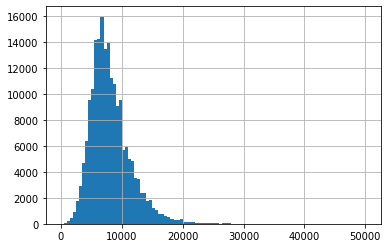

In [34]:
df_s[columns.PRICE_M2].hist(bins=100)

In [5]:
string

NameError: name 'string' is not defined

In [ ]:
df_r.head()